In [1]:
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from feature_functions import *
from scipy.spatial import KDTree
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.preprocessing import StandardScaler  # for feature scaling
import sklearn.model_selection as model_selection  # for data splitting
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV  # for choosing the best set of hyper parameters
import pandas as pd
from statsmodels.graphics.mosaicplot import mosaic
from scipy.stats import gaussian_kde
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
import itertools

folder_path = "D:\\Geomatics\\Q3\\GEO5017 ML\\assignments\\asgn_2_collab\\data\\pointclouds\\*.xyz"

txt_files = glob.glob(folder_path)

### Load all .xyz files

In [2]:
# create an empty list to hold numpy arrays
arrays_list = []

# loop through each file and read its contents into a numpy array
for file_path in txt_files:
    with open(file_path, 'r') as file:
        file_contents = file.readlines()
        file_array = np.array([np.array(line.strip().split()).astype(float) for line in file_contents])
        arrays_list.append(file_array)

# convert the list of numpy arrays into a numpy array of arrays
numpy_array = np.array(arrays_list, dtype=object)

number_of_files = len(numpy_array)

### Calculate features

In [3]:
point_cloud_features = []

for i in range(number_of_files):

    # assign feature number
    feature_dictionary = {}
    feature_dictionary['item_id'] = i

    # assign original classification
    original_classification = original_classifier(i)
    feature_dictionary['original classification'] = original_classification

    # calculate number of points
    number_of_points = len(numpy_array[i])
    feature_dictionary['number_of_points'] = number_of_points

    # Linearity
    covariance = np.cov(numpy_array[i].T)
    eigen_values = np.linalg.eigvals(covariance)
    eigen_values.sort()
    eigenvalues = eigen_values[::-1]
    linearity = (eigen_values[0]-eigen_values[1]) / eigen_values[0]
    feature_dictionary['linearity'] = -linearity

    # Sphericality
    center_x,center_y,center_z = compute_centroid(i,number_of_points,numpy_array[i])
    total_dist = distance_to_center(center_x,center_y,center_z,numpy_array[i],number_of_points)
    avg_dist = avg_distance_to_center(total_dist,number_of_points)
    rmse = rms_distance(total_dist,number_of_points)
    sphericality = avg_dist / rmse
    feature_dictionary['sphericality'] = sphericality

    # Verticality
    vert = verticality(10,numpy_array[i])
    feature_dictionary['verticality'] = vert

    # Planarity
    planarity = compute_planarity(numpy_array[i])
    feature_dictionary['planarity'] = planarity

    # point normals x
    eigvals, eigvecs = np.linalg.eig(covariance)
    min_eigval_idx = np.argmin(eigvals)
    normal = eigvecs[:,min_eigval_idx]
    normal_x = normal[0]
    feature_dictionary['point_normals_x'] = normal_x

    # point normals y
    normal_y = normal[1]
    feature_dictionary['point_normals_y'] = normal_y

    # point normals z
    normal_z = normal[2]
    feature_dictionary['point_normals_z'] = normal_z

    # bounding box size
    x1,y1,z1,x2,y2,z2 = compute_bounding_box(number_of_points,numpy_array[i])
    volume = box_size(x1,y1,z1,x2,y2,z2)
    feature_dictionary['bounding_box_size'] = volume

    # avg distance to centroid
    feature_dictionary['average_distance_to_centroid'] = avg_dist

    # Covariance xyz cov(X,Y,Z)=E[(x−E[X])(y−E[Y])(z−E[Z])]=(x−E[X])(y−E[Y])(z−E[Z])
    cov = covariance_over_xyz(numpy_array[i],number_of_points)
    feature_dictionary["covariance_over_xyz"] = cov

    # RMSE
    feature_dictionary['root_mean_square_error'] = rmse

    # Spread over x
    spread_x = spread_over_x(number_of_points,numpy_array[i])
    feature_dictionary['spread_over_x'] = spread_x

    # Spread over y
    spread_y = spread_over_y(number_of_points,numpy_array[i])
    feature_dictionary['spread_over_y'] = spread_y

    # Spread over z
    spread_z = spread_over_z(number_of_points,numpy_array[i])
    feature_dictionary['spread_over_z'] = spread_z

    # Assign dictionary to list of dictionaries
    point_cloud_features.append(feature_dictionary)

### SVM Classifier

In [4]:
# all the features
feature_scaling_features = ["sphericality", "number_of_points", "linearity", "average_distance_to_centroid",
                            "bounding_box_size", "root_mean_square_error", "spread_over_x", "spread_over_y", 
                            "spread_over_z", "verticality","point_normals_x","point_normals_y","point_normals_z",
                            "planarity", "covariance_over_xyz"]

#### preparing the data

In [5]:
data_df = pd.DataFrame(point_cloud_features)  ## making a data frame from dictionary which has both # X, y combined  
X = data_df[feature_scaling_features]  # Features' values of examples 
y = data_df['original classification']  # with actual classification names (trees, cars, buildings, etc)

### RBF learning curve using all the parameters

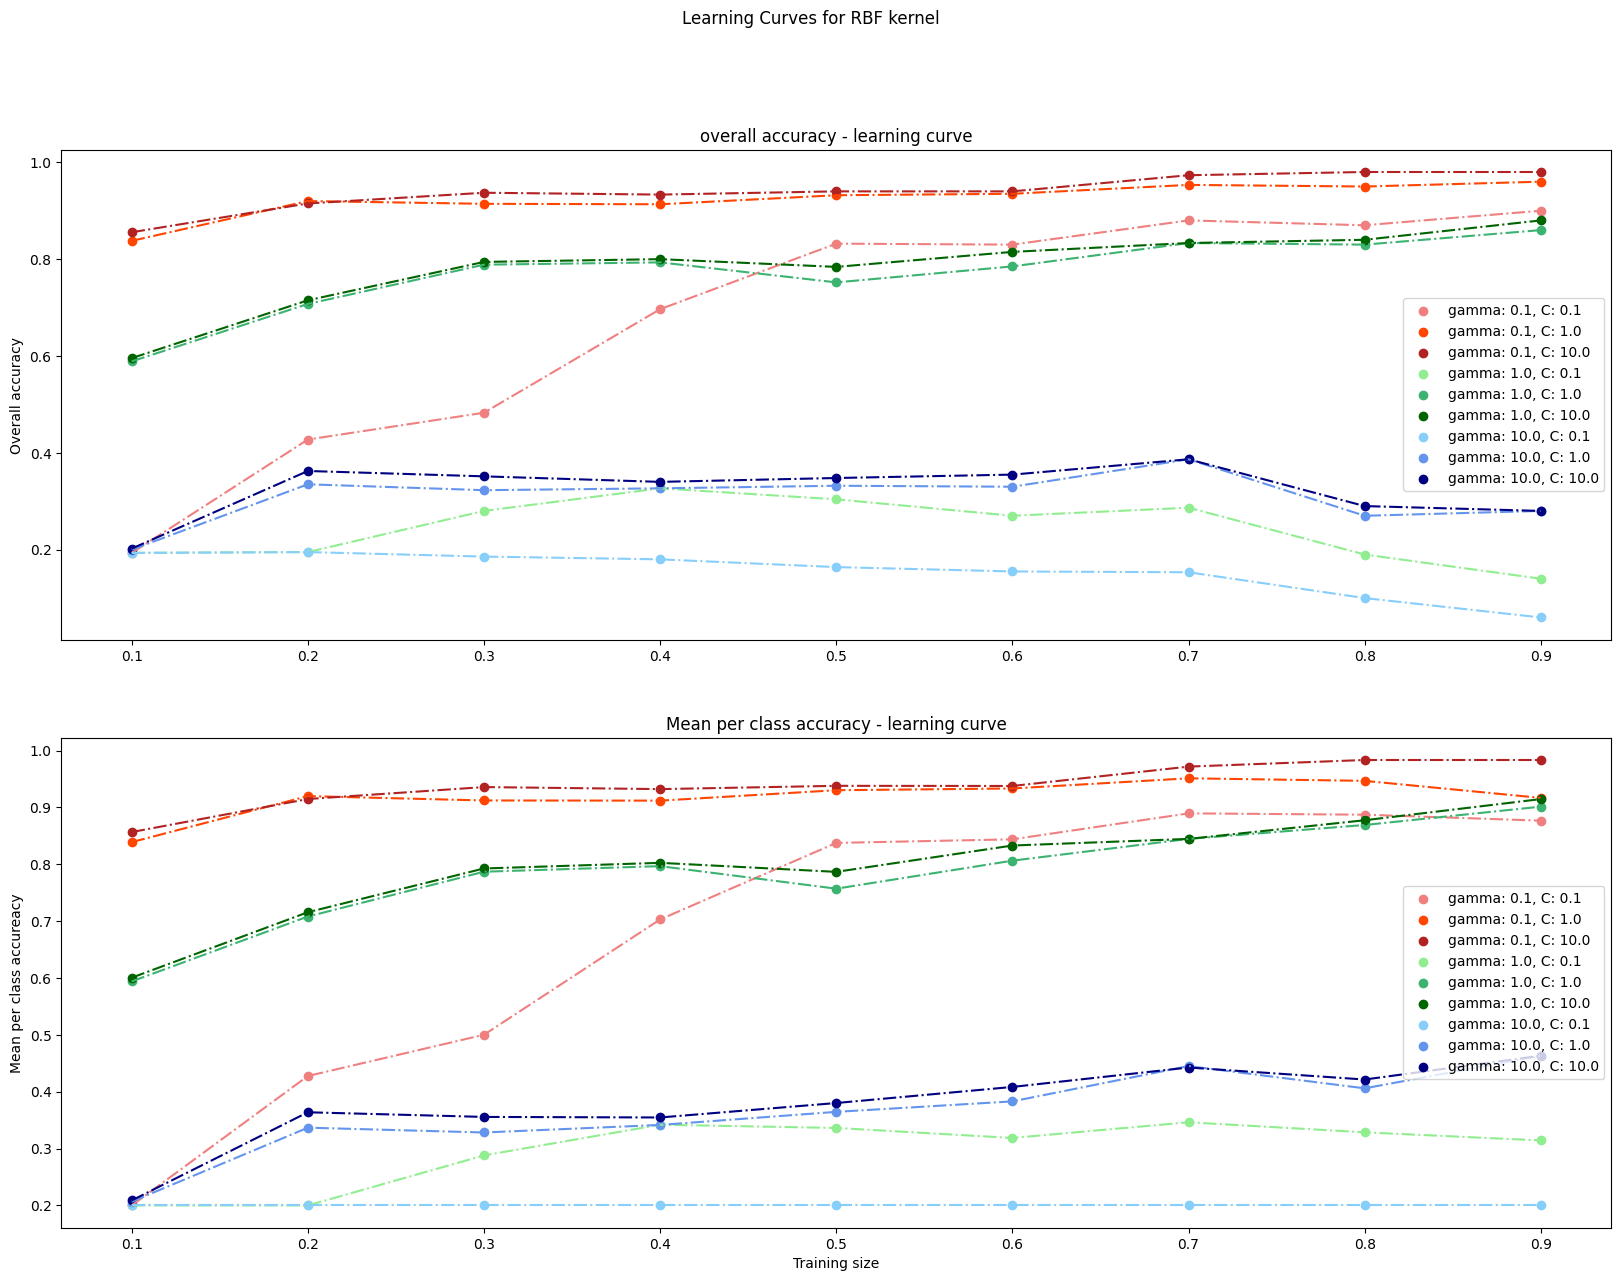

In [19]:
plt.close()

training_size = np.arange(0.1, 1.0, 0.1)  # 50% of the examples is training data
test_size = 1 - training_size
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(20, 14))

C_array = np.array((0.1, 1, 10))
gamma_array = np.array((0.1, 1, 10))
C_grid, gamma_grid = np.meshgrid(C_array, gamma_array)
C_gamma_combinations = [np.array([C_grid.ravel()[i], gamma_grid.ravel()[i]]) for i in range(len(C_grid.ravel()))]

for C_and_gamma in C_gamma_combinations:
    C = C_and_gamma[0]
    gamma = C_and_gamma[1]
    
    acc_with_train_size = []  # accuracy with training size
    mean_perclass_acc_with_train_size = []  # mean perclass accuracy with training size
    for size in training_size:
        train_size = np.round(size, 1)
        test_size = np.round(1 - train_size, 1)
        # training and test data split
        X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=train_size, test_size=test_size, random_state=42)

        # Feature scaling training data
        scaler = StandardScaler()
        scaler.fit(X_train)
        scaled_X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
        scaled_X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
        # rbf kernel
        rbf = svm.SVC(kernel='rbf', gamma=gamma, C=C).fit(scaled_X_train, y_train)
        rbf_predict = rbf.predict(scaled_X_test)
        rbf_accuracy = accuracy_score(y_test, rbf_predict)
        cm = confusion_matrix(y_test, rbf_predict)  # confusion matrix
        per_class_accuracy = np.diag(cm) / cm.sum(axis=1)
        mean_per_class_accuracy = np.mean(per_class_accuracy)

        acc_with_train_size.append(rbf_accuracy)
        mean_perclass_acc_with_train_size.append(mean_per_class_accuracy)

    if (gamma == 0.1 and C == 0.1):
        axs[0].plot(training_size, acc_with_train_size, "-.", c="lightcoral")
        axs[0].scatter(training_size, acc_with_train_size, c="lightcoral", label=f"gamma: {gamma}, C: {C}")
        axs[1].plot(training_size, mean_perclass_acc_with_train_size, "-.", c="lightcoral")
        axs[1].scatter(training_size, mean_perclass_acc_with_train_size, c="lightcoral", label=f"gamma: {gamma}, C: {C}")
    elif (gamma == 0.1 and C == 1):
        axs[0].plot(training_size, acc_with_train_size, "-.",  c="orangered")
        axs[0].scatter(training_size, acc_with_train_size, c="orangered", label=f"gamma: {gamma}, C: {C}")
        axs[1].plot(training_size, mean_perclass_acc_with_train_size, "-.",  c="orangered")
        axs[1].scatter(training_size, mean_perclass_acc_with_train_size, c="orangered", label=f"gamma: {gamma}, C: {C}")
    elif (gamma == 0.1 and C == 10):
        axs[0].plot(training_size, acc_with_train_size, "-.", c="firebrick")
        axs[0].scatter(training_size, acc_with_train_size, c="firebrick", label=f"gamma: {gamma}, C: {C}")
        axs[1].plot(training_size, mean_perclass_acc_with_train_size, "-.", c="firebrick")
        axs[1].scatter(training_size, mean_perclass_acc_with_train_size, c="firebrick", label=f"gamma: {gamma}, C: {C}")
    elif (gamma == 1 and C == 0.1):
        axs[0].plot(training_size, acc_with_train_size, "-.", c="lightgreen")
        axs[0].scatter(training_size, acc_with_train_size, c="lightgreen", label=f"gamma: {gamma}, C: {C}")
        axs[1].plot(training_size, mean_perclass_acc_with_train_size, "-.", c="lightgreen")
        axs[1].scatter(training_size, mean_perclass_acc_with_train_size, c="lightgreen", label=f"gamma: {gamma}, C: {C}")
    elif (gamma == 1 and C == 1):
        axs[0].plot(training_size, acc_with_train_size, "-.", c="mediumseagreen")
        axs[0].scatter(training_size, acc_with_train_size, c="mediumseagreen", label=f"gamma: {gamma}, C: {C}")
        axs[1].plot(training_size, mean_perclass_acc_with_train_size, "-.", c="mediumseagreen")
        axs[1].scatter(training_size, mean_perclass_acc_with_train_size, c="mediumseagreen", label=f"gamma: {gamma}, C: {C}")
    elif (gamma == 1 and C == 10):
        axs[0].plot(training_size, acc_with_train_size, "-.", c="darkgreen")
        axs[0].scatter(training_size, acc_with_train_size, c="darkgreen", label=f"gamma: {gamma}, C: {C}")    
        axs[1].plot(training_size, mean_perclass_acc_with_train_size, "-.", c="darkgreen")
        axs[1].scatter(training_size, mean_perclass_acc_with_train_size, c="darkgreen", label=f"gamma: {gamma}, C: {C}")
    elif (gamma == 10 and C == 0.1):
        axs[0].plot(training_size, acc_with_train_size, "-.", c="lightskyblue")
        axs[0].scatter(training_size, acc_with_train_size, c="lightskyblue", label=f"gamma: {gamma}, C: {C}")
        axs[1].plot(training_size, mean_perclass_acc_with_train_size, "-.", c="lightskyblue")
        axs[1].scatter(training_size, mean_perclass_acc_with_train_size, c="lightskyblue", label=f"gamma: {gamma}, C: {C}")
    elif (gamma == 10 and C == 1):
        axs[0].plot(training_size, acc_with_train_size, "-.", c="cornflowerblue")
        axs[0].scatter(training_size, acc_with_train_size, c="cornflowerblue", label=f"gamma: {gamma}, C: {C}")
        axs[1].plot(training_size, mean_perclass_acc_with_train_size, "-.", c="cornflowerblue")
        axs[1].scatter(training_size, mean_perclass_acc_with_train_size, c="cornflowerblue", label=f"gamma: {gamma}, C: {C}")
    elif (gamma == 10 and C == 10):
        axs[0].plot(training_size, acc_with_train_size, "-.", c="navy")
        axs[0].scatter(training_size, acc_with_train_size, c="navy", label=f"gamma: {gamma}, C: {C}")
        axs[1].plot(training_size, mean_perclass_acc_with_train_size, "-.", c="navy")
        axs[1].scatter(training_size, mean_perclass_acc_with_train_size, c="navy", label=f"gamma: {gamma}, C: {C}")
    

axs[0].set_ylabel("Overall accuracy")
axs[1].set_ylabel("Mean per class accureacy")
# axs[0].set_title("Learning curve - Overall accuracy - with training size")
axs[0].legend(loc='right')
axs[1].legend(loc='right')
axs[1].set_xlabel("Training size")
axs[1].set_xlabel("Training size")
axs[0].set_title("overall accuracy - learning curve")
axs[1].set_title("Mean per class accuracy - learning curve")
fig.suptitle("Learning Curves for RBF kernel")
plt.show()

### Polynomial Kernel - Learning Curve using all the parameters

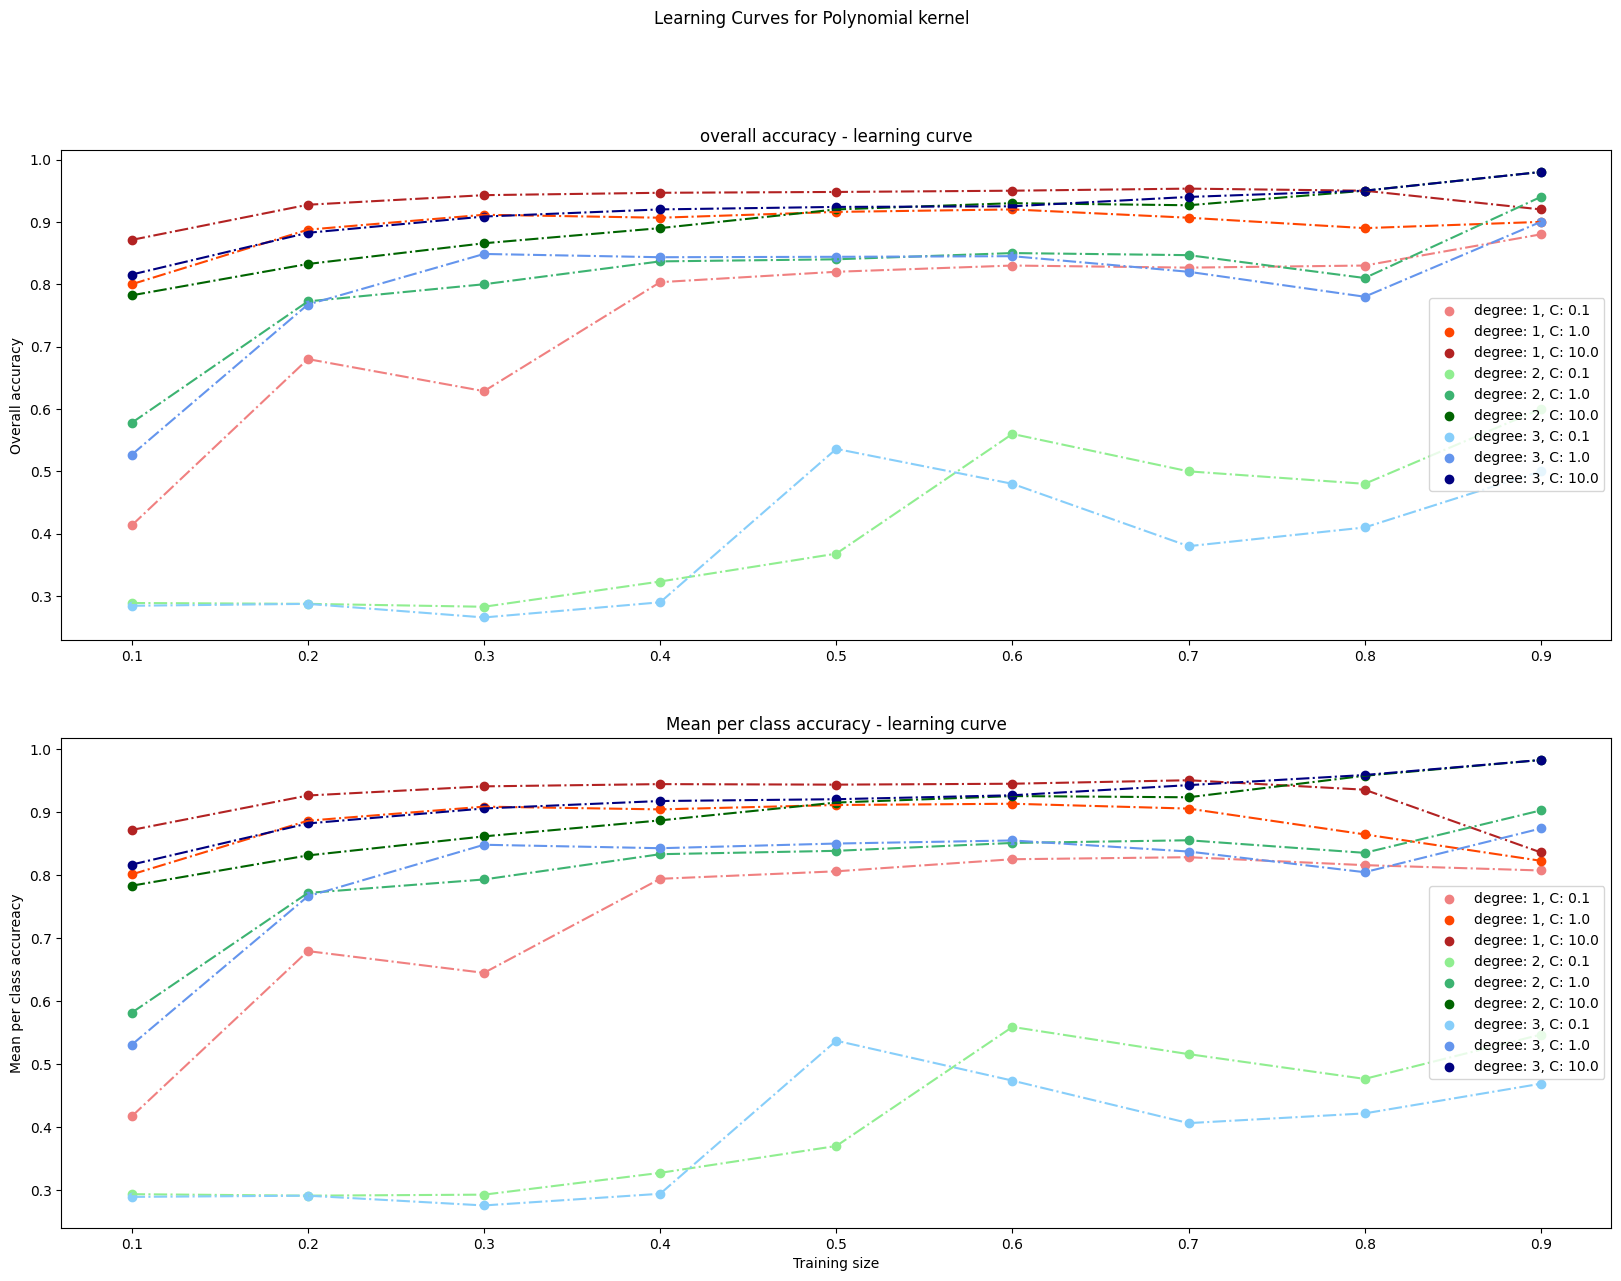

In [24]:
plt.close()

training_size = np.arange(0.1, 1.0, 0.1)  # 50% of the examples is training data
test_size = 1 - training_size
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(20, 14))

C_array = np.array((0.1, 1, 10))
degree_array = np.array((1, 2, 3))
C_grid, degree_grid = np.meshgrid(C_array, degree_array)
C_degree_combinations = [np.array([C_grid.ravel()[i], degree_grid.ravel()[i]]) for i in range(len(C_grid.ravel()))]
for C_and_degree in C_degree_combinations:
    C = C_and_degree[0]
    degree = C_and_degree[1]
    
    acc_with_train_size = []  # accuracy with training size
    mean_perclass_acc_with_train_size = []  # mean perclass accuracy with training size
    for size in training_size:
        train_size = np.round(size, 1)
        test_size = np.round(1 - train_size, 1)
        # training and test data split
        X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=train_size, test_size=test_size, random_state=42)

        # Feature scaling training data
        scaler = StandardScaler()
        scaler.fit(X_train)
        scaled_X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
        scaled_X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
        # poly kernel
        poly = svm.SVC(kernel='poly', degree=int(degree), C=C).fit(scaled_X_train, y_train)
        poly_predict = poly.predict(scaled_X_test)
        poly_accuracy = accuracy_score(y_test, poly_predict)
        cm = confusion_matrix(y_test,poly_predict)  # confusion matrix
        per_class_accuracy = np.diag(cm) / cm.sum(axis=1)
        mean_per_class_accuracy = np.mean(per_class_accuracy)

        acc_with_train_size.append(poly_accuracy)
        mean_perclass_acc_with_train_size.append(mean_per_class_accuracy)

    if (degree == 1 and C == 0.1):
        axs[0].plot(training_size, acc_with_train_size, "-.", c="lightcoral")
        axs[0].scatter(training_size, acc_with_train_size, c="lightcoral", label=f"degree: {int(degree)}, C: {C}")
        axs[1].plot(training_size, mean_perclass_acc_with_train_size, "-.", c="lightcoral")
        axs[1].scatter(training_size, mean_perclass_acc_with_train_size, c="lightcoral", label=f"degree: {int(degree)}, C: {C}")
    elif (degree == 1 and C == 1):
        axs[0].plot(training_size, acc_with_train_size, "-.",  c="orangered")
        axs[0].scatter(training_size, acc_with_train_size, c="orangered", label=f"degree: {int(degree)}, C: {C}")
        axs[1].plot(training_size, mean_perclass_acc_with_train_size, "-.",  c="orangered")
        axs[1].scatter(training_size, mean_perclass_acc_with_train_size, c="orangered", label=f"degree: {int(degree)}, C: {C}")
    elif (degree == 1 and C == 10):
        axs[0].plot(training_size, acc_with_train_size, "-.", c="firebrick")
        axs[0].scatter(training_size, acc_with_train_size, c="firebrick", label=f"degree: {int(degree)}, C: {C}")
        axs[1].plot(training_size, mean_perclass_acc_with_train_size, "-.", c="firebrick")
        axs[1].scatter(training_size, mean_perclass_acc_with_train_size, c="firebrick", label=f"degree: {int(degree)}, C: {C}")
    elif (degree == 2 and C == 0.1):
        axs[0].plot(training_size, acc_with_train_size, "-.", c="lightgreen")
        axs[0].scatter(training_size, acc_with_train_size, c="lightgreen", label=f"degree: {int(degree)}, C: {C}")
        axs[1].plot(training_size, mean_perclass_acc_with_train_size, "-.", c="lightgreen")
        axs[1].scatter(training_size, mean_perclass_acc_with_train_size, c="lightgreen", label=f"degree: {int(degree)}, C: {C}")
    elif (degree == 2 and C == 1):
        axs[0].plot(training_size, acc_with_train_size, "-.", c="mediumseagreen")
        axs[0].scatter(training_size, acc_with_train_size, c="mediumseagreen", label=f"degree: {int(degree)}, C: {C}")
        axs[1].plot(training_size, mean_perclass_acc_with_train_size, "-.", c="mediumseagreen")
        axs[1].scatter(training_size, mean_perclass_acc_with_train_size, c="mediumseagreen", label=f"degree: {int(degree)}, C: {C}")
    elif (degree == 2 and C == 10):
        axs[0].plot(training_size, acc_with_train_size, "-.", c="darkgreen")
        axs[0].scatter(training_size, acc_with_train_size, c="darkgreen", label=f"degree: {int(degree)}, C: {C}")    
        axs[1].plot(training_size, mean_perclass_acc_with_train_size, "-.", c="darkgreen")
        axs[1].scatter(training_size, mean_perclass_acc_with_train_size, c="darkgreen", label=f"degree: {int(degree)}, C: {C}")
    elif (degree == 3 and C == 0.1):
        axs[0].plot(training_size, acc_with_train_size, "-.", c="lightskyblue")
        axs[0].scatter(training_size, acc_with_train_size, c="lightskyblue", label=f"degree: {int(degree)}, C: {C}")
        axs[1].plot(training_size, mean_perclass_acc_with_train_size, "-.", c="lightskyblue")
        axs[1].scatter(training_size, mean_perclass_acc_with_train_size, c="lightskyblue", label=f"degree: {int(degree)}, C: {C}")
    elif (degree == 3 and C == 1):
        axs[0].plot(training_size, acc_with_train_size, "-.", c="cornflowerblue")
        axs[0].scatter(training_size, acc_with_train_size, c="cornflowerblue", label=f"degree: {int(degree)}, C: {C}")
        axs[1].plot(training_size, mean_perclass_acc_with_train_size, "-.", c="cornflowerblue")
        axs[1].scatter(training_size, mean_perclass_acc_with_train_size, c="cornflowerblue", label=f"degree: {int(degree)}, C: {C}")
    elif (degree == 3 and C == 10):
        axs[0].plot(training_size, acc_with_train_size, "-.", c="navy")
        axs[0].scatter(training_size, acc_with_train_size, c="navy", label=f"degree: {int(degree)}, C: {C}")
        axs[1].plot(training_size, mean_perclass_acc_with_train_size, "-.", c="navy")
        axs[1].scatter(training_size, mean_perclass_acc_with_train_size, c="navy", label=f"degree: {int(degree)}, C: {C}")
    

axs[0].set_ylabel("Overall accuracy")
axs[1].set_ylabel("Mean per class accureacy")
# axs[0].set_title("Learning curve - Overall accuracy - with training size")
axs[0].legend(loc='right')
axs[1].legend(loc='right')
axs[1].set_xlabel("Training size")
axs[1].set_xlabel("Training size")
axs[0].set_title("overall accuracy - learning curve")
axs[1].set_title("Mean per class accuracy - learning curve")
fig.suptitle("Learning Curves for Polynomial kernel")
plt.show()

### Finding best combination of features for RBF SVM

In [47]:
train_size = 0.6
test_size = 1-train_size
features_sizes = np.arange(2, 16, 1)
gamma = 0.1
C = 10.0
rbf_best_features_combination_overall_accu = {}
rbf_best_features_combination_mean_per_class_accu = {}

for features_size in features_sizes:
    features_combinations = list(itertools.combinations(feature_scaling_features, features_size))
    features_combinations = [list(combination) for combination in features_combinations]
    rbf_features_accu_dict = {}
    rbf_features_meanperclass_accu_dict = {}

    for combination in features_combinations:
        X_train, X_test, y_train, y_test = model_selection.train_test_split(X[combination], y, train_size=train_size, test_size=test_size, random_state=10)
        # Feature scaling training data
        scaler = StandardScaler()
        scaler.fit(X_train)
        scaled_X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
        scaled_X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
        # rbf kernel
        rbf = svm.SVC(kernel='rbf', gamma=gamma, C=C).fit(scaled_X_train, y_train)
        rbf_predict = rbf.predict(scaled_X_test)
        rbf_accuracy = accuracy_score(y_test, rbf_predict)
        cm = confusion_matrix(y_test, rbf_predict)  # confusion matrix
        per_class_accuracy = np.diag(cm) / cm.sum(axis=1)
        mean_per_class_accuracy = np.mean(per_class_accuracy)
        rbf_features_accu_dict[tuple(combination)] = rbf_accuracy
        rbf_features_meanperclass_accu_dict[tuple(combination)] = mean_per_class_accuracy
    
    max_key, max_value = max(rbf_features_accu_dict.items(), key=lambda x: x[1])
    max_key_perclass, max_value_perclass = max(rbf_features_meanperclass_accu_dict.items(), key=lambda x: x[1])
    rbf_best_features_combination_overall_accu[max_key] = max_value
    rbf_best_features_combination_mean_per_class_accu[max_key_perclass] = max_value_perclass

Text(0.5, 0.98, 'RBF SVM - Accuracy vs Number of features (C=10.0 & gamma=0.1)')

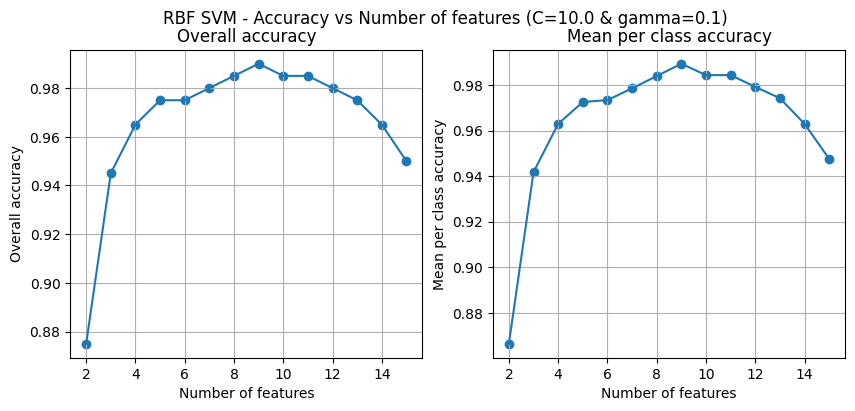

In [48]:
plt.close()
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axs[0].plot(features_sizes, rbf_best_features_combination_overall_accu.values())
axs[0].scatter(features_sizes, rbf_best_features_combination_overall_accu.values())
axs[0].set_xlabel("Number of features")
axs[0].set_ylabel("Overall accuracy")
axs[0].set_title("Overall accuracy")
axs[0].grid()

axs[1].plot(features_sizes, rbf_best_features_combination_mean_per_class_accu.values())
axs[1].scatter(features_sizes, rbf_best_features_combination_mean_per_class_accu.values())
axs[1].set_xlabel("Number of features")
axs[1].set_ylabel("Mean per class accuracy")
axs[1].set_title("Mean per class accuracy")
axs[1].grid()

fig.suptitle("RBF SVM - Accuracy vs Number of features (C=10.0 & gamma=0.1)")


In [49]:
rbf_best_features_combination_overall_accu

{('sphericality', 'spread_over_z'): 0.875,
 ('sphericality', 'average_distance_to_centroid', 'spread_over_z'): 0.945,
 ('sphericality',
  'average_distance_to_centroid',
  'spread_over_z',
  'point_normals_y'): 0.965,
 ('sphericality',
  'average_distance_to_centroid',
  'root_mean_square_error',
  'spread_over_z',
  'point_normals_z'): 0.975,
 ('sphericality',
  'number_of_points',
  'average_distance_to_centroid',
  'spread_over_z',
  'verticality',
  'point_normals_z'): 0.975,
 ('sphericality',
  'linearity',
  'average_distance_to_centroid',
  'root_mean_square_error',
  'spread_over_y',
  'spread_over_z',
  'point_normals_z'): 0.98,
 ('sphericality',
  'number_of_points',
  'average_distance_to_centroid',
  'spread_over_y',
  'spread_over_z',
  'point_normals_z',
  'planarity',
  'covariance_over_xyz'): 0.985,
 ('sphericality',
  'linearity',
  'average_distance_to_centroid',
  'root_mean_square_error',
  'spread_over_y',
  'spread_over_z',
  'point_normals_z',
  'planarity',
  'c

#### Classification report for RBF SVM

In [66]:
# finding the combination of 9 features which gave the best accuracy
for key in rbf_best_features_combination_overall_accu.keys():
    if len(key) == 9:
        best_rbf_feature_combination = key
        break
best_rbf_feature_combination = [combination for combination in best_rbf_feature_combination]
print(best_rbf_feature_combination)
# Creating the classifier again
X_train, X_test, y_train, y_test = model_selection.train_test_split(X[best_rbf_feature_combination], y, train_size=train_size, test_size=test_size, random_state=10)
# Feature scaling training data
scaler = StandardScaler()
scaler.fit(X_train)
scaled_X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
scaled_X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
# rbf kernel
rbf = svm.SVC(kernel='rbf', gamma=gamma, C=C).fit(scaled_X_train, y_train)
rbf_predict = rbf.predict(scaled_X_test)
rbf_cm = confusion_matrix(y_test, rbf_predict)
rbf_report = classification_report(y_test, rbf_predict)
print(rbf_report)
print(rbf_cm)

['sphericality', 'linearity', 'average_distance_to_centroid', 'root_mean_square_error', 'spread_over_y', 'spread_over_z', 'point_normals_z', 'planarity', 'covariance_over_xyz']
              precision    recall  f1-score   support

    building       1.00      0.97      0.99        39
         car       0.98      1.00      0.99        48
       fence       0.97      0.97      0.97        36
        pole       1.00      1.00      1.00        40
        tree       1.00      1.00      1.00        37

    accuracy                           0.99       200
   macro avg       0.99      0.99      0.99       200
weighted avg       0.99      0.99      0.99       200

[[38  0  1  0  0]
 [ 0 48  0  0  0]
 [ 0  1 35  0  0]
 [ 0  0  0 40  0]
 [ 0  0  0  0 37]]


### Finding best combination of features for Poly SVM

In [50]:
train_size = 0.6
test_size = 1-train_size
features_sizes = np.arange(2, 16, 1)
degree = 1
C = 10.0
poly_best_features_combination_overall_accu = {}
poly_best_features_combination_mean_per_class_accu = {}

for features_size in features_sizes:
    features_combinations = list(itertools.combinations(feature_scaling_features, features_size))
    features_combinations = [list(combination) for combination in features_combinations]
    poly_features_accu_dict = {}
    poly_features_meanperclass_accu_dict = {}

    for combination in features_combinations:
        X_train, X_test, y_train, y_test = model_selection.train_test_split(X[combination], y, train_size=train_size, test_size=test_size, random_state=10)
        # Feature scaling training data
        scaler = StandardScaler()
        scaler.fit(X_train)
        scaled_X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
        scaled_X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
        # rbf kernel
        rbf = svm.SVC(kernel='poly', degree=degree, C=C).fit(scaled_X_train, y_train)
        rbf_predict = rbf.predict(scaled_X_test)
        rbf_accuracy = accuracy_score(y_test, rbf_predict)
        cm = confusion_matrix(y_test, rbf_predict)  # confusion matrix
        per_class_accuracy = np.diag(cm) / cm.sum(axis=1)
        mean_per_class_accuracy = np.mean(per_class_accuracy)
        poly_features_accu_dict[tuple(combination)] = rbf_accuracy
        poly_features_meanperclass_accu_dict[tuple(combination)] = mean_per_class_accuracy
    
    max_key, max_value = max(poly_features_accu_dict.items(), key=lambda x: x[1])
    max_key_perclass, max_value_perclass = max(poly_features_meanperclass_accu_dict.items(), key=lambda x: x[1])
    poly_best_features_combination_overall_accu[max_key] = max_value
    poly_best_features_combination_mean_per_class_accu[max_key_perclass] = max_value_perclass

Text(0.5, 0.98, 'Polynomial SVM - Accuracy vs Number of features (C=10.0 & degree=1)')

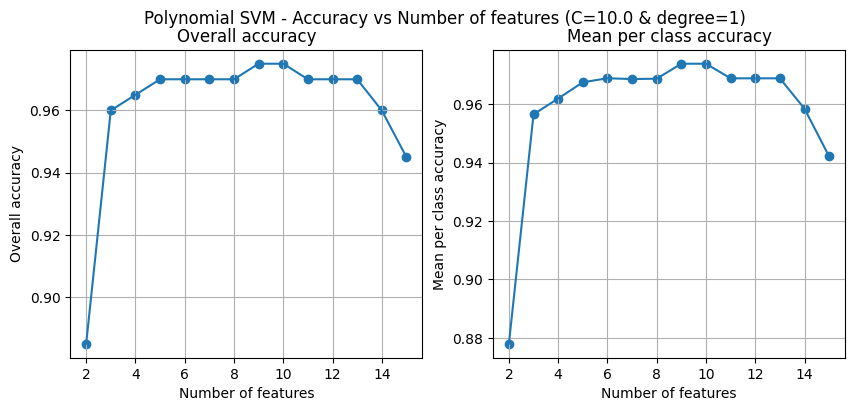

In [51]:
plt.close()
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axs[0].plot(features_sizes, poly_best_features_combination_overall_accu.values())
axs[0].scatter(features_sizes, poly_best_features_combination_overall_accu.values())
axs[0].set_xlabel("Number of features")
axs[0].set_ylabel("Overall accuracy")
axs[0].set_title("Overall accuracy")
axs[0].grid()

axs[1].plot(features_sizes, poly_best_features_combination_mean_per_class_accu.values())
axs[1].scatter(features_sizes, poly_best_features_combination_mean_per_class_accu.values())
axs[1].set_xlabel("Number of features")
axs[1].set_ylabel("Mean per class accuracy")
axs[1].set_title("Mean per class accuracy")
axs[1].grid()

fig.suptitle("Polynomial SVM - Accuracy vs Number of features (C=10.0 & degree=1)")

In [54]:
poly_best_features_combination_overall_accu

{('sphericality', 'spread_over_z'): 0.885,
 ('sphericality', 'average_distance_to_centroid', 'spread_over_z'): 0.96,
 ('sphericality',
  'average_distance_to_centroid',
  'spread_over_z',
  'point_normals_z'): 0.965,
 ('sphericality',
  'linearity',
  'root_mean_square_error',
  'spread_over_z',
  'planarity'): 0.97,
 ('sphericality',
  'number_of_points',
  'average_distance_to_centroid',
  'spread_over_x',
  'spread_over_z',
  'verticality'): 0.97,
 ('sphericality',
  'number_of_points',
  'linearity',
  'average_distance_to_centroid',
  'spread_over_x',
  'spread_over_z',
  'point_normals_z'): 0.97,
 ('sphericality',
  'number_of_points',
  'linearity',
  'average_distance_to_centroid',
  'bounding_box_size',
  'spread_over_x',
  'spread_over_z',
  'point_normals_z'): 0.97,
 ('sphericality',
  'number_of_points',
  'linearity',
  'average_distance_to_centroid',
  'root_mean_square_error',
  'spread_over_z',
  'point_normals_z',
  'planarity',
  'covariance_over_xyz'): 0.975,
 ('sphe

### Classification report for Polynomial SVM

In [64]:
# finding the combination of 9 features which gave the best accuracy
for key in poly_best_features_combination_overall_accu.keys():
    if len(key) == 10:
        best_poly_feature_combination = key
        break
best_poly_feature_combination = [combination for combination in best_poly_feature_combination]
print(best_poly_feature_combination)
# Creating the classifier again
X_train, X_test, y_train, y_test = model_selection.train_test_split(X[best_poly_feature_combination], y, train_size=train_size, test_size=test_size, random_state=10)
# Feature scaling training data
scaler = StandardScaler()
scaler.fit(X_train)
scaled_X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
scaled_X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
# poly kernel
poly = svm.SVC(kernel='poly', degree=degree, C=C).fit(scaled_X_train, y_train)
poly_predict = poly.predict(scaled_X_test)
poly_report = classification_report(y_test, poly_predict)
poly_cm = confusion_matrix(y_test, poly_predict)  # confusion matrix
print(poly_report)
print(poly_cm)

['sphericality', 'number_of_points', 'linearity', 'average_distance_to_centroid', 'root_mean_square_error', 'spread_over_x', 'spread_over_z', 'point_normals_x', 'point_normals_z', 'covariance_over_xyz']
              precision    recall  f1-score   support

    building       1.00      1.00      1.00        39
         car       0.92      1.00      0.96        48
       fence       1.00      0.92      0.96        36
        pole       0.98      1.00      0.99        40
        tree       1.00      0.95      0.97        37

    accuracy                           0.97       200
   macro avg       0.98      0.97      0.98       200
weighted avg       0.98      0.97      0.97       200

[[39  0  0  0  0]
 [ 0 48  0  0  0]
 [ 0  3 33  0  0]
 [ 0  0  0 40  0]
 [ 0  1  0  1 35]]
